In [8]:
%load_ext autoreload
%autoreload 2
from GraphCreator import *
from utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Neural Network Model

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class my_gcn_softmax(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes, dropout, device):
        super(my_gcn_softmax, self).__init__()
        self.dropout_frac = dropout
        self.conv1 = GraphConv(in_feats, hidden_size).to(device)
        self.conv2 = GraphConv(hidden_size, num_classes).to(device)

    def forward(self, g, inputs):
        h = self.conv1(g, inputs)
        h = F.relu(h)
        h = F.dropout(h, p=self.dropout_frac, training=self.training)
        h = self.conv2(g, h)
        h = F.softmax(h, dim=1)  # Apply softmax over the classes dimension
        return h

# Graph 1 Test

## Graph creation

(None,
 tensor([[ 0., 10.,  0.,  0.,  0.,  0.,  0.],
         [10.,  0.,  1.,  0.,  0.,  0.,  0.],
         [ 0.,  1.,  0.,  1.,  0.,  1.,  0.],
         [ 0.,  0.,  1.,  0., 10.,  0.,  0.],
         [ 0.,  0.,  0., 10.,  0.,  0.,  0.],
         [ 0.,  0.,  1.,  0.,  0.,  0., 10.],
         [ 0.,  0.,  0.,  0.,  0., 10.,  0.]]))

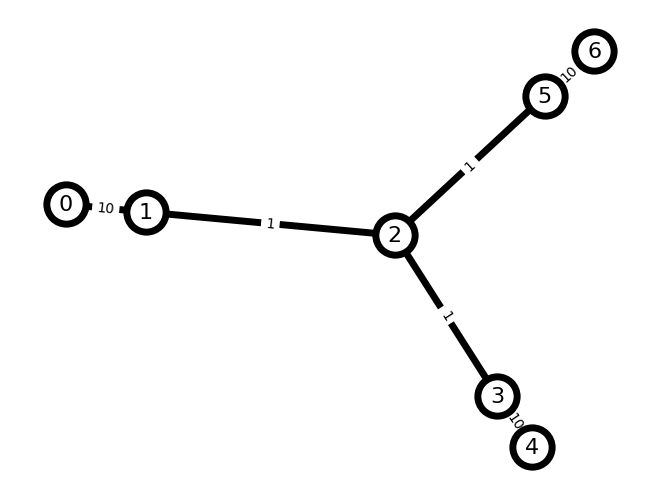

In [10]:
edges = [(0,1, {"weight": 10, "capacity":10}),
         (1,2, {"weight": 1, "capacity":1}),
         (2,3, {"weight": 1, "capacity":1}),
         (3,4, {"weight": 10, "capacity":10}),
         (2,5, {"weight": 1, "capacity":1}),
         (5,6, {"weight": 10, "capacity":10}),]
graph = CreateDummyFunction(edges)
graph_dgl = dgl.from_networkx(nx_graph=graph)
graph_dgl = graph_dgl.to(TORCH_DEVICE)
q_torch = qubo_dict_to_torch(graph, gen_adj_matrix(graph), torch_dtype=TORCH_DTYPE, torch_device=TORCH_DEVICE)

DrawGraph(graph), q_torch

## HyperParameters initialization

In [11]:
n, d, p, graph_type, number_epochs, learning_rate, PROB_THRESHOLD, tol, patience, dim_embedding, hidden_dim = hyperParameters(n=7,patience=1000)
# Establish pytorch GNN + optimizer
opt_params = {'lr': learning_rate}
gnn_hypers = {
    'dim_embedding': dim_embedding+1,
    'hidden_dim': hidden_dim,
    'dropout': 0.0,
    'number_classes': 3,
    'prob_threshold': PROB_THRESHOLD,
    'number_epochs': number_epochs,
    'tolerance': tol,
    'patience': patience
}

In [12]:
# Construct graph to learn on
def get_gnn(n_nodes, gnn_hypers, opt_params, torch_device, torch_dtype):
    """
    Generate GNN instance with specified structure. Creates GNN, retrieves embedding layer,
    and instantiates ADAM optimizer given those.

    Input:
        n_nodes: Problem size (number of nodes in graph)
        gnn_hypers: Hyperparameters relevant to GNN structure
        opt_params: Hyperparameters relevant to ADAM optimizer
        torch_device: Whether to load pytorch variables onto CPU or GPU
        torch_dtype: Datatype to use for pytorch variables
    Output:
        net: GNN instance
        embed: Embedding layer to use as input to GNN
        optimizer: ADAM optimizer instance
    """
    dim_embedding = gnn_hypers['dim_embedding']
    hidden_dim = gnn_hypers['hidden_dim']
    dropout = gnn_hypers['dropout']
    number_classes = gnn_hypers['number_classes']

    # instantiate the GNN
    net = my_gcn_softmax(dim_embedding, hidden_dim, number_classes, dropout, torch_device)
    net = net.type(torch_dtype).to(torch_device)
    embed = nn.Embedding(n_nodes, dim_embedding)
    embed = embed.type(torch_dtype).to(torch_device)

    # set up Adam optimizer
    params = chain(net.parameters(), embed.parameters())
    optimizer = torch.optim.Adam(params, **opt_params)
    return net, embed, optimizer

net, embed, optimizer = get_gnn(n, gnn_hypers, opt_params, TORCH_DEVICE, TORCH_DTYPE)


In [18]:
def calculate_HA_vectorized(s):
    """
    Vectorized calculation of HA.
    :param s: A binary matrix of size |V| x |K| where s[i][j] is 1 if vertex i is in partition j.
    :return: The HA value.
    """
    # HA = ∑v∈V(∑k∈K(sv,k)−1)^2
    HA = torch.sum((torch.sum(s, axis=1) - 1) ** 2)
    return HA

def calculate_HC_vectorized_old(s, adjacency_matrix):
    """
    Vectorized calculation of HC.
    :param s: A binary matrix of size |V| x |K|.
    :param adjacency_matrix: A matrix representing the graph where the value at [i][j] is the weight of the edge between i and j.
    :return: The HC value.
    """
    # HC = ∑(u,v)∈E(1−∑k∈K(su,k*sv,k))*adjacency_matrix[u,v]
    K = s.shape[1]
    # Outer product to find pairs of vertices in the same partition and then weight by the adjacency matrix
    prod = adjacency_matrix * (1 - s @ s.T)
    HC = torch.sum(prod)
    return HC

def calculate_HC_vectorized(s, adjacency_matrix):
    """
    Vectorized calculation of HC for soft partitioning.
    :param s: A probability matrix of size |V| x |K| where s[i][j] is the probability of vertex i being in partition j.
    :param adjacency_matrix: A matrix representing the graph where the value at [i][j] is the weight of the edge between i and j.
    :return: The HC value.
    """
    # Initialize HC to 0
    HC = 0

    # Iterate over each partition to calculate its contribution to HC
    for k in range(s.shape[1]):
        # Compute the probability matrix for partition k
        partition_prob_matrix = s[:, k].unsqueeze(1) * s[:, k].unsqueeze(0)

        # Compute the contribution to HC for partition k
        HC_k =adjacency_matrix * (1 - partition_prob_matrix)
        # Sum up the contributions for partition k
        HC += torch.sum(HC_k, dim=(0, 1))

    # Since we've summed up the partition contributions twice (due to symmetry), divide by 2
    HC = HC / 2

    return HC

def Loss_2(s, adjacency_matrix, A = 1, C = 1):
    HA = calculate_HA_vectorized(s)
    HC = calculate_HC_vectorized(s, adjacency_matrix)

    return A*HA + C*HC

def Loss(s, adjacency_matrix, terminal_nodes = {1: 0, 5: 1, 3: 2}, A=1, C=1):
    # Exclude terminal nodes from HA calculation
    non_terminal_nodes = [node for node in range(s.size(0)) if node not in terminal_nodes]
    HA = calculate_HA_vectorized(s[non_terminal_nodes])

    # Include terminal nodes in HC calculation
    # with their predetermined partitions
    adjusted_s = s.clone()
    for node, partition in terminal_nodes.items():
        adjusted_s[node] = torch.zeros_like(s[node])  # Reset probabilities
        adjusted_s[node][partition] = 1  # Set probability to 1 for the designated partition

    HC = calculate_HC_vectorized(adjusted_s, adjacency_matrix)

    return A * HA + C * HC


## Neural Network

In [14]:
class GCN_dev(nn.Module):
    def __init__(self, in_feats, hidden_size, number_classes, dropout, device):
        """
        Initialize a new instance of the core GCN model of provided size.
        Dropout is added in forward step.

        Inputs:
            in_feats: Dimension of the input (embedding) layer
            hidden_size: Hidden layer size
            dropout: Fraction of dropout to add between intermediate layer. Value is cached for later use.
            device: Specifies device (CPU vs GPU) to load variables onto
        """
        super(GCN_dev, self).__init__()

        self.dropout_frac = dropout
        self.conv1 = GraphConv(in_feats, hidden_size).to(device)
        self.conv2 = GraphConv(hidden_size, number_classes).to(device)

    def forward(self, g, inputs):
        """
        Run forward propagation step of instantiated model.

        Input:
            self: GCN_dev instance
            g: DGL graph object, i.e. problem definition
            inputs: Input (embedding) layer weights, to be propagated through network
        Output:
            h: Output layer weights
        """

        # input step
        h = self.conv1(g, inputs)
        h = torch.relu(h)
        h = F.dropout(h, p=self.dropout_frac)

        # output step
        h = self.conv2(g, h)
        h = torch.sigmoid(h)



        return h

In [15]:
# Assuming gpt_gcn_softmax is similar to my_gcn_softmax, but with the potential for additional tweaks
# such as incorporating node features that indicate the desired partition of terminal nodes.

class gpt_gcn_softmax(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes, dropout, device):
        super(gpt_gcn_softmax, self).__init__()
        self.dropout_frac = dropout
        self.conv1 = GraphConv(in_feats, hidden_size).to(device)
        self.conv2 = GraphConv(hidden_size, num_classes).to(device)

    def forward(self, g, inputs):
        # inputs should include the node features indicating the desired partition of terminal nodes
        h = self.conv1(g, inputs)
        h = F.relu(h)
        h = F.dropout(h, p=self.dropout_frac, training=self.training)
        h = self.conv2(g, h)
        h = F.softmax(h, dim=1) # Apply softmax over the classes dimension
        return h

In [16]:
def run_gnn_training(q_torch, dgl_graph, net, embed, optimizer, number_epochs, tol, patience, prob_threshold, loss_func, terminal_nodes= {1: 0, 5: 1, 3: 2}, nodes_count = 5, total_classes = 2):
    """
    Wrapper function to run and monitor GNN training. Includes early stopping.
    """
    # Assign variable for user reference
    inputs = embed.weight

    prev_loss = 1.  # initial loss value (arbitrary)
    count = 0       # track number times early stopping is triggered

    # initialize optimal solution
    best_bitstring = torch.zeros(nodes_count,total_classes).type(q_torch.dtype).to(q_torch.device)
    best_loss = loss_func(best_bitstring.float(), q_torch, terminal_nodes)

    t_gnn_start = time()


    # Training logic
    for epoch in range(number_epochs):

        # get logits/activations
        probs = net(dgl_graph, inputs)  # collapse extra dimension output from model

        #############Orig
        # # Adjust probabilities for terminal nodes
        # for node, partition in terminal_nodes.items():
        #     probs[node] = torch.zeros_like(probs[node])  # Reset probabilities
        #     probs[node][partition] = 1
        #
        #     # build cost value with QUBO cost function
        # loss = loss_func(probs, q_torch)
        ############Orig eNotADirectoryError

        # ########### Modify 1
        # # Create a new tensor for adjusted probabilities
        # adjusted_probs = probs.clone()
        #
        # # Adjust probabilities for terminal nodes
        # for node, partition in terminal_nodes.items():
        #     adjusted_probs[node] = torch.zeros_like(probs[node])  # Reset probabilities
        #     adjusted_probs[node][partition] = 1  # Set probability to 1 for the designated partition
        #     # Use adjusted_probs instead of probs for loss calculation
        # loss = loss_func(adjusted_probs, q_torch)
        # ########### Modify 1 End


        loss = loss_func(probs, q_torch, terminal_nodes)
        loss_ = loss.detach().item()

        # Apply projection
        bitstring = (probs.detach() >= prob_threshold) * 1
        if loss < best_loss:

            bitstring = assignTerminals(terminal_nodes, bitstring, probs)

            best_loss = loss
            best_bitstring = bitstring

        if epoch % 1000 == 0:
            print(f'Epoch: {epoch}, Loss: {loss_}')

        # early stopping check
        # If loss increases or change in loss is too small, trigger
        if (abs(loss_ - prev_loss) <= tol) | ((loss_ - prev_loss) > 0):
            count += 1
        else:
            count = 0

        if count >= patience:
            print(f'Stopping early on epoch {epoch} (patience: {patience})')
            break

        # update loss tracking
        prev_loss = loss_

        # run optimization with backpropagation
        optimizer.zero_grad()  # clear gradient for step
        loss.backward()        # calculate gradient through compute graph
        optimizer.step()       # take step, update weights

    t_gnn = time() - t_gnn_start
    print(f'GNN training (n={dgl_graph.number_of_nodes()}) took {round(t_gnn, 3)}')
    print(f'GNN final continuous loss: {loss_}')
    print(f'GNN best continuous loss: {best_loss}')

    # raw_bitstring = probs.detach()
    # final_bitstring = (probs.detach() >= prob_threshold) * 1

    # After training loop
    raw_bitstring = probs.detach()

    raw_bitstring = assignTerminals(terminal_nodes, raw_bitstring, probs)
    # # Adjust the raw_bitstring for terminal nodes
    # for node, partition in terminal_nodes.items():
    #     raw_bitstring[node] = torch.zeros_like(probs[node])  # Reset probabilities
    #     raw_bitstring[node][partition] = 1  # Set probability to 1 for the designated partition

    # Convert the adjusted raw_bitstring to final binary partitioning
    final_bitstring = (raw_bitstring >= prob_threshold) * 1

    return net, epoch, final_bitstring, best_bitstring, raw_bitstring

In [17]:
# Runing multiple instance of GNN

best_gnn_final = []
best_gnn_bitstring = []
best_cut_value = torch.inf
best_gnn_model = None
best_index = 0
terminal_nodes= {1: 0, 5: 1, 3: 2}
for i in range(5):

    n, d, p, graph_type, number_epochs, learning_rate, PROB_THRESHOLD, tol, patience, dim_embedding, hidden_dim = hyperParameters(n=7,patience=1000)

    # Establish pytorch GNN + optimizer
    opt_params = {'lr': learning_rate}
    gnn_hypers = {
        'dim_embedding': dim_embedding,
        'hidden_dim': hidden_dim,
        'dropout': 0.0,
        'number_classes': 3,
        'prob_threshold': PROB_THRESHOLD,
        'number_epochs': number_epochs,
        'tolerance': tol,
        'patience': patience,
        'nodes':n
    }

    net, embed, optimizer = get_gnn(n, gnn_hypers, opt_params, TORCH_DEVICE, TORCH_DTYPE)

    trained_net, epoch, final_bitstring, best_bitstring , raw_bitstring= run_gnn_training(
        q_torch, graph_dgl, net, embed, optimizer, int(1e5),
        gnn_hypers['tolerance'], gnn_hypers['patience'], gnn_hypers['prob_threshold'], Loss, terminal_nodes, gnn_hypers['nodes'], gnn_hypers['number_classes'])

    final_cutVale = calculateAllCut(q_torch, final_bitstring)
    best_cutValue = calculateAllCut(q_torch, best_bitstring)

    if torch.min(final_cutVale, best_cutValue) < best_cut_value:
        best_cut_value = torch.min(final_cutVale, best_cutValue)
        best_gnn_final = final_bitstring
        best_gnn_bitstring = best_bitstring
        best_gnn_model = trained_net
        best_index = i
    print(torch.min(final_cutVale, best_cutValue))


best_gnn_bitstring, best_gnn_final, best_cut_value

Epoch: 0, Loss: 263.0264892578125
Epoch: 1000, Loss: 260.0704040527344
Epoch: 2000, Loss: 255.29254150390625
Epoch: 3000, Loss: 250.36903381347656
Epoch: 4000, Loss: 245.55523681640625
Epoch: 5000, Loss: 241.77178955078125
Epoch: 6000, Loss: 239.0724334716797
Epoch: 7000, Loss: 237.06414794921875
Epoch: 8000, Loss: 235.34609985351562
Epoch: 9000, Loss: 233.5454864501953
Epoch: 10000, Loss: 231.56167602539062
Epoch: 11000, Loss: 229.49032592773438
Epoch: 12000, Loss: 227.43194580078125
Epoch: 13000, Loss: 225.4533233642578
Epoch: 14000, Loss: 223.59402465820312
Epoch: 15000, Loss: 221.8746337890625
Epoch: 16000, Loss: 220.30078125
Epoch: 17000, Loss: 218.86813354492188
Epoch: 18000, Loss: 217.563720703125
Epoch: 19000, Loss: 216.37136840820312
Epoch: 20000, Loss: 215.27732849121094
Epoch: 21000, Loss: 214.27325439453125
Epoch: 22000, Loss: 213.3526611328125
Epoch: 23000, Loss: 212.51019287109375
Epoch: 24000, Loss: 211.74005126953125
Epoch: 25000, Loss: 211.0375213623047
Epoch: 26000, L

(tensor([[1, 0, 0],
         [1, 0, 0],
         [0, 0, 1],
         [0, 0, 1],
         [0, 0, 1],
         [0, 1, 0],
         [0, 1, 0]]),
 tensor([[1, 0, 0],
         [1, 0, 0],
         [0, 0, 1],
         [0, 0, 1],
         [0, 0, 1],
         [0, 1, 0],
         [0, 1, 0]]),
 tensor(2., dtype=torch.float64))

In [13]:
best_gnn_bitstring, best_gnn_final, best_cut_value, best_index

(tensor([[1, 0, 0],
         [1, 0, 0],
         [0, 1, 0],
         [0, 0, 1],
         [0, 0, 1],
         [0, 1, 0],
         [0, 1, 0]]),
 tensor([[1, 0, 0],
         [1, 0, 0],
         [0, 1, 0],
         [0, 0, 1],
         [0, 0, 1],
         [0, 1, 0],
         [0, 1, 0]]),
 tensor(2., dtype=torch.float64),
 1)

(None,
 tensor([[0., 6., 4., 4., 5., 0., 0.],
         [6., 0., 0., 0., 9., 0., 9.],
         [4., 0., 0., 0., 0., 1., 9.],
         [4., 0., 0., 0., 4., 8., 1.],
         [5., 9., 0., 4., 0., 5., 0.],
         [0., 0., 1., 8., 5., 0., 0.],
         [0., 9., 9., 1., 0., 0., 0.]]))

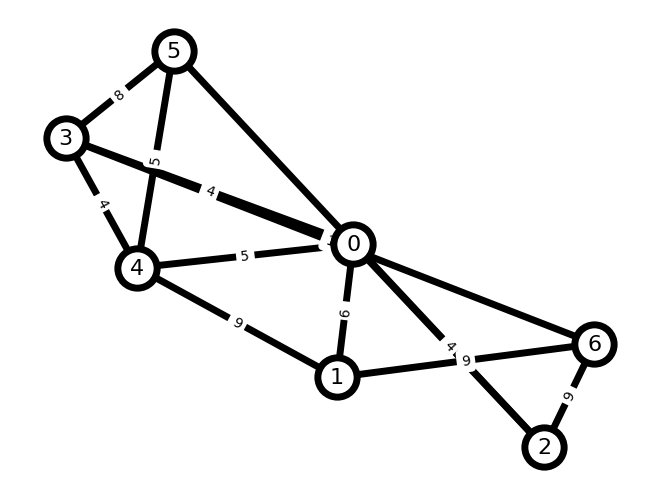

In [38]:
edges = [(0, 1, {'weight': 6, 'capacity': 6}),
         (0, 2, {'weight': 4, 'capacity': 4}),
         (0, 3, {'weight': 4, 'capacity': 4}),
         (0, 4, {'weight': 5, 'capacity': 5}),
         (1, 4, {'weight': 9, 'capacity': 9}),
         (1, 6, {'weight': 9, 'capacity': 9}),
         (2, 5, {'weight': 1, 'capacity': 1}),
         (2, 6, {'weight': 9, 'capacity': 9}),
         (3, 4, {'weight': 4, 'capacity': 4}),
         (3, 5, {'weight': 8, 'capacity': 8}),
         (3, 6, {'weight': 1, 'capacity': 1}),
         (4, 5, {'weight': 5, 'capacity': 5})
    ,]
graph = CreateDummyFunction(edges)
graph_dgl = dgl.from_networkx(nx_graph=graph)
graph_dgl = graph_dgl.to(TORCH_DEVICE)
q_torch = qubo_dict_to_torch(graph, gen_adj_matrix(graph), torch_dtype=TORCH_DTYPE, torch_device=TORCH_DEVICE)

DrawGraph(graph), q_torch

In [39]:
# Runing multiple instance of GNN

best_gnn_final = []
best_gnn_bitstring = []
best_cut_value = torch.inf
best_gnn_model = None
best_index = 0

terminal_nodes= {1: 0, 5: 1, 3: 2}
for i in range(5):
    n, d, p, graph_type, number_epochs, learning_rate, PROB_THRESHOLD, tol, patience, dim_embedding, hidden_dim = hyperParameters(n=7,patience=1000)

    # Establish pytorch GNN + optimizer
    opt_params = {'lr': learning_rate}
    gnn_hypers = {
        'dim_embedding': dim_embedding,
        'hidden_dim': hidden_dim,
        'dropout': 0.0,
        'number_classes': 3,
        'prob_threshold': PROB_THRESHOLD,
        'number_epochs': number_epochs,
        'tolerance': tol,
        'patience': patience,
        'nodes':n
    }

    net, embed, optimizer = get_gnn(n, gnn_hypers, opt_params, TORCH_DEVICE, TORCH_DTYPE)

    trained_net, epoch, final_bitstring, best_bitstring , raw_bitstring= run_gnn_training(
        q_torch, graph_dgl, net, embed, optimizer, int(1e5),
        gnn_hypers['tolerance'], gnn_hypers['patience'], gnn_hypers['prob_threshold'], Loss, terminal_nodes, gnn_hypers['nodes'], gnn_hypers['number_classes'])

    final_cutVale = calculateAllCut(q_torch, final_bitstring)
    best_cutValue = calculateAllCut(q_torch, best_bitstring)

    if torch.min(final_cutVale, best_cutValue) < best_cut_value:
        best_cut_value = torch.min(final_cutVale, best_cutValue)
        best_gnn_final = final_bitstring
        best_gnn_bitstring = best_bitstring
        best_gnn_model = trained_net
        best_index = i

best_gnn_bitstring, best_gnn_final, best_cut_value

Epoch: 0, Loss: 170.11965942382812
Epoch: 1000, Loss: 161.3235321044922
Epoch: 2000, Loss: 156.18310546875
Epoch: 3000, Loss: 154.40521240234375
Epoch: 4000, Loss: 153.6936798095703
Epoch: 5000, Loss: 153.36647033691406
Epoch: 6000, Loss: 153.20162963867188
Epoch: 7000, Loss: 153.11367797851562
Stopping early on epoch 7604 (patience: 1000)
GNN training (n=7) took 10.65
GNN final continuous loss: 153.0810546875
GNN best continuous loss: 153.0810546875
Epoch: 0, Loss: 175.97183227539062
Epoch: 1000, Loss: 175.04196166992188
Epoch: 2000, Loss: 173.66192626953125
Epoch: 3000, Loss: 171.54501342773438
Epoch: 4000, Loss: 168.9546356201172
Epoch: 5000, Loss: 166.24549865722656
Epoch: 6000, Loss: 161.01480102539062
Epoch: 7000, Loss: 157.15521240234375
Epoch: 8000, Loss: 155.32220458984375
Epoch: 9000, Loss: 154.3115692138672
Epoch: 10000, Loss: 153.74020385742188
Epoch: 11000, Loss: 153.41659545898438
Epoch: 12000, Loss: 153.2340087890625
Epoch: 13000, Loss: 153.13150024414062
Stopping early 

(tensor([[1, 0, 0],
         [1, 0, 0],
         [1, 0, 0],
         [0, 0, 1],
         [1, 0, 0],
         [0, 1, 0],
         [1, 0, 0]]),
 tensor([[1, 0, 0],
         [1, 0, 0],
         [1, 0, 0],
         [0, 0, 1],
         [1, 0, 0],
         [0, 1, 0],
         [1, 0, 0]]),
 tensor(23., dtype=torch.float64))

In [17]:
best_gnn_bitstring, best_gnn_final, best_cut_value, best_index

(tensor([[1, 0, 0],
         [1, 0, 0],
         [1, 0, 0],
         [0, 0, 1],
         [1, 0, 0],
         [0, 1, 0],
         [1, 0, 0]]),
 tensor([[1, 0, 0],
         [1, 0, 0],
         [1, 0, 0],
         [0, 0, 1],
         [1, 0, 0],
         [0, 1, 0],
         [1, 0, 0]]),
 tensor(23., dtype=torch.float64),
 0)

# Graph 3 (experimental 2-way cut)

(None,
 tensor([[0., 8., 1., 0., 0.],
         [8., 0., 0., 1., 0.],
         [1., 0., 0., 1., 1.],
         [0., 1., 1., 0., 1.],
         [0., 0., 1., 1., 0.]]))

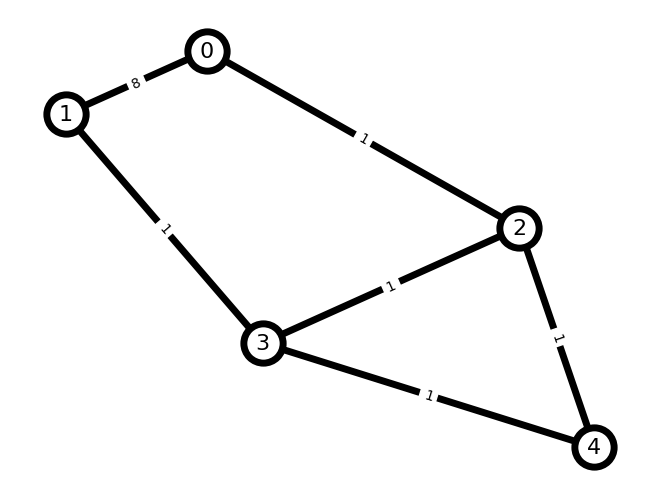

In [24]:
edges = [(0,1, {"weight": 8, "capacity":8}),
         (0,2, {"weight": 1, "capacity":1}),
         (1,3, {"weight": 1, "capacity":1}),
         (2,3, {"weight": 1, "capacity":1}),
         (2,4, {"weight": 1, "capacity":1}),
         (3,4, {"weight": 1, "capacity":1})]

graph = CreateDummyFunction(edges)
graph_dgl = dgl.from_networkx(nx_graph=graph)
graph_dgl = graph_dgl.to(TORCH_DEVICE)
q_torch = qubo_dict_to_torch(graph, gen_adj_matrix(graph), torch_dtype=TORCH_DTYPE, torch_device=TORCH_DEVICE)

DrawGraph(graph), q_torch

In [25]:
# Runing multiple instance of GNN

best_gnn_final = []
best_gnn_bitstring = []
best_cut_value = torch.inf
best_gnn_model = None
best_index = 0
terminal_nodes = {0: 0, 2: 1}
for i in range(5):

    n, d, p, graph_type, number_epochs, learning_rate, PROB_THRESHOLD, tol, patience, dim_embedding, hidden_dim = hyperParameters(n=5,patience=1000)

    # Establish pytorch GNN + optimizer
    opt_params = {'lr': learning_rate}
    gnn_hypers = {
        'dim_embedding': dim_embedding,
        'hidden_dim': hidden_dim,
        'dropout': 0.0,
        'number_classes': 2,
        'prob_threshold': PROB_THRESHOLD,
        'number_epochs': number_epochs,
        'tolerance': tol,
        'patience': patience,
        'nodes':n
    }

    net, embed, optimizer = get_gnn(n, gnn_hypers, opt_params, TORCH_DEVICE, TORCH_DTYPE)

    trained_net, epoch, final_bitstring, best_bitstring , raw_bitstring= run_gnn_training(
        q_torch, graph_dgl, net, embed, optimizer, int(1e5),
        gnn_hypers['tolerance'], gnn_hypers['patience'], gnn_hypers['prob_threshold'], Loss, terminal_nodes, gnn_hypers['nodes'], gnn_hypers['number_classes'])

    final_cutVale = calculateAllCut(q_torch, final_bitstring)
    best_cutValue = calculateAllCut(q_torch, best_bitstring)

    if torch.min(final_cutVale, best_cutValue) < best_cut_value:
        best_cut_value = torch.min(final_cutVale, best_cutValue)
        best_gnn_final = final_bitstring
        best_gnn_bitstring = best_bitstring
        best_gnn_model = trained_net
        best_index = i

best_gnn_bitstring, best_gnn_final, best_cut_value

Epoch: 0, Loss: 19.91643714904785
Epoch: 1000, Loss: 18.671899795532227
Epoch: 2000, Loss: 17.458160400390625
Epoch: 3000, Loss: 16.796972274780273
Epoch: 4000, Loss: 16.41190528869629
Epoch: 5000, Loss: 16.206920623779297
Epoch: 6000, Loss: 16.10727310180664
Stopping early on epoch 6478 (patience: 1000)
GNN training (n=5) took 9.01
GNN final continuous loss: 16.07924461364746
GNN best continuous loss: 16.07924461364746
Epoch: 0, Loss: 19.992523193359375
Epoch: 1000, Loss: 19.6463623046875
Epoch: 2000, Loss: 19.310943603515625
Epoch: 3000, Loss: 18.801570892333984
Epoch: 4000, Loss: 18.297311782836914
Epoch: 5000, Loss: 17.828330993652344
Epoch: 6000, Loss: 17.391130447387695
Epoch: 7000, Loss: 16.991744995117188
Epoch: 8000, Loss: 16.641212463378906
Epoch: 9000, Loss: 16.346017837524414
Epoch: 10000, Loss: 16.104530334472656
Epoch: 11000, Loss: 15.909857749938965
Epoch: 12000, Loss: 15.753334045410156
Epoch: 13000, Loss: 15.626971244812012
Epoch: 14000, Loss: 15.524205207824707
Epoch:

(tensor([[1, 0],
         [1, 0],
         [0, 1],
         [0, 1],
         [0, 1]]),
 tensor([[1, 0],
         [1, 0],
         [0, 1],
         [0, 1],
         [0, 1]]),
 tensor(2., dtype=torch.float64))

# graph 4 (2 -way partition)

Number of edges: 2501
Sample edges: [(0, 1, {'weight': 7, 'capacity': 7}), (0, 3, {'weight': 4, 'capacity': 4}), (0, 5, {'weight': 10, 'capacity': 10}), (0, 6, {'weight': 0, 'capacity': 0}), (0, 7, {'weight': 1, 'capacity': 1})]


(None,
 tensor([[0., 7., 0.,  ..., 0., 2., 0.],
         [7., 0., 0.,  ..., 0., 0., 6.],
         [0., 0., 0.,  ..., 3., 3., 0.],
         ...,
         [0., 0., 3.,  ..., 0., 4., 7.],
         [2., 0., 3.,  ..., 4., 0., 0.],
         [0., 6., 0.,  ..., 7., 0., 0.]]))

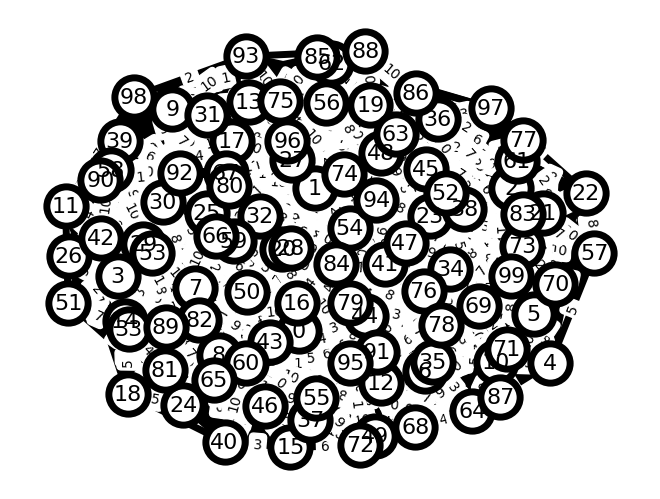

In [28]:
graph = CreateGraph(100)
graph_dgl = dgl.from_networkx(nx_graph=graph)
graph_dgl = graph_dgl.to(TORCH_DEVICE)
q_torch = qubo_dict_to_torch(graph, gen_adj_matrix(graph), torch_dtype=TORCH_DTYPE, torch_device=TORCH_DEVICE)

DrawGraph(graph), q_torch

In [29]:
cut_value_AB, partition_AB = nx.minimum_cut(graph, 0, 60)
cut_value_AB, partition_AB

(309,
 ({0,
   1,
   2,
   3,
   4,
   5,
   6,
   7,
   8,
   9,
   10,
   11,
   12,
   13,
   14,
   15,
   16,
   17,
   18,
   19,
   20,
   21,
   22,
   23,
   24,
   25,
   26,
   27,
   28,
   29,
   30,
   31,
   32,
   33,
   34,
   35,
   36,
   37,
   38,
   39,
   40,
   41,
   42,
   43,
   44,
   45,
   46,
   47,
   48,
   49,
   50,
   51,
   52,
   53,
   54,
   55,
   56,
   57,
   58,
   59,
   61,
   62,
   63,
   64,
   65,
   66,
   67,
   68,
   69,
   70,
   71,
   72,
   73,
   74,
   75,
   76,
   77,
   78,
   79,
   80,
   81,
   82,
   83,
   84,
   85,
   86,
   87,
   88,
   89,
   90,
   91,
   92,
   93,
   94,
   95,
   96,
   97,
   98,
   99},
  {60}))

In [30]:
# Runing multiple instance of GNN

best_gnn_final = []
best_gnn_bitstring = []
best_cut_value = torch.inf
best_gnn_model = None
best_index = 0
terminal_nodes = {0: 0, 60: 1}
for i in range(5):

    n, d, p, graph_type, number_epochs, learning_rate, PROB_THRESHOLD, tol, patience, dim_embedding, hidden_dim = hyperParameters(n=100,patience=1000)

    # Establish pytorch GNN + optimizer
    opt_params = {'lr': learning_rate}
    gnn_hypers = {
        'dim_embedding': dim_embedding,
        'hidden_dim': hidden_dim,
        'dropout': 0.0,
        'number_classes': 2,
        'prob_threshold': PROB_THRESHOLD,
        'number_epochs': number_epochs,
        'tolerance': tol,
        'patience': patience,
        'nodes':n
    }

    net, embed, optimizer = get_gnn(n, gnn_hypers, opt_params, TORCH_DEVICE, TORCH_DTYPE)

    trained_net, epoch, final_bitstring, best_bitstring , raw_bitstring= run_gnn_training(
        q_torch, graph_dgl, net, embed, optimizer, int(1e5),
        gnn_hypers['tolerance'], gnn_hypers['patience'], gnn_hypers['prob_threshold'], Loss, terminal_nodes, gnn_hypers['nodes'], gnn_hypers['number_classes'])

    final_cutVale = calculateAllCut(q_torch, final_bitstring)
    best_cutValue = calculateAllCut(q_torch, best_bitstring)

    if torch.min(final_cutVale, best_cutValue) < best_cut_value:
        best_cut_value = torch.min(final_cutVale, best_cutValue)
        best_gnn_final = final_bitstring
        best_gnn_bitstring = best_bitstring
        best_gnn_model = trained_net
        best_index = i

best_gnn_bitstring, best_gnn_final, best_cut_value

Epoch: 0, Loss: 19039.1015625
Epoch: 1000, Loss: 14456.2587890625
Epoch: 2000, Loss: 13238.8701171875
Epoch: 3000, Loss: 13081.095703125
Epoch: 4000, Loss: 13038.9951171875
Epoch: 5000, Loss: 13023.4736328125
Epoch: 6000, Loss: 13016.7236328125
Epoch: 7000, Loss: 13013.5029296875
Epoch: 8000, Loss: 13011.8740234375
Epoch: 9000, Loss: 13011.021484375
Epoch: 10000, Loss: 13010.5654296875
Epoch: 11000, Loss: 13010.3154296875
Epoch: 12000, Loss: 13010.1767578125
Epoch: 13000, Loss: 13010.099609375
Epoch: 14000, Loss: 13010.056640625
Epoch: 15000, Loss: 13010.0322265625
Epoch: 16000, Loss: 13010.0185546875
Epoch: 17000, Loss: 13010.0107421875
Epoch: 18000, Loss: 13010.005859375
Epoch: 19000, Loss: 13010.00390625
Epoch: 20000, Loss: 13010.001953125
Epoch: 21000, Loss: 13010.0009765625
Stopping early on epoch 21290 (patience: 1000)
GNN training (n=100) took 31.433
GNN final continuous loss: 13010.0009765625
GNN best continuous loss: 13010.0009765625
Epoch: 0, Loss: 19017.99609375
Epoch: 1000,

(tensor([[1, 0],
         [1, 0],
         [1, 0],
         [1, 0],
         [1, 0],
         [1, 0],
         [1, 0],
         [1, 0],
         [1, 0],
         [1, 0],
         [1, 0],
         [1, 0],
         [1, 0],
         [1, 0],
         [1, 0],
         [1, 0],
         [1, 0],
         [1, 0],
         [1, 0],
         [1, 0],
         [1, 0],
         [1, 0],
         [1, 0],
         [1, 0],
         [1, 0],
         [1, 0],
         [1, 0],
         [1, 0],
         [1, 0],
         [1, 0],
         [1, 0],
         [1, 0],
         [1, 0],
         [1, 0],
         [1, 0],
         [1, 0],
         [1, 0],
         [1, 0],
         [1, 0],
         [1, 0],
         [1, 0],
         [1, 0],
         [1, 0],
         [1, 0],
         [1, 0],
         [1, 0],
         [1, 0],
         [1, 0],
         [1, 0],
         [1, 0],
         [1, 0],
         [1, 0],
         [1, 0],
         [1, 0],
         [1, 0],
         [1, 0],
         [1, 0],
         [1, 0],
         [1, 0

# Graph 5 (2-way cut)

Number of edges: 9994
Sample edges: [(0, 2, {'weight': 6, 'capacity': 6}), (0, 4, {'weight': 3, 'capacity': 3}), (0, 6, {'weight': 5, 'capacity': 5}), (0, 7, {'weight': 9, 'capacity': 9}), (0, 8, {'weight': 2, 'capacity': 2})]


(None,
 tensor([[0., 0., 6.,  ..., 0., 0., 0.],
         [0., 0., 6.,  ..., 6., 6., 0.],
         [6., 6., 0.,  ..., 3., 0., 0.],
         ...,
         [0., 6., 3.,  ..., 0., 6., 6.],
         [0., 6., 0.,  ..., 6., 0., 7.],
         [0., 0., 0.,  ..., 6., 7., 0.]]))

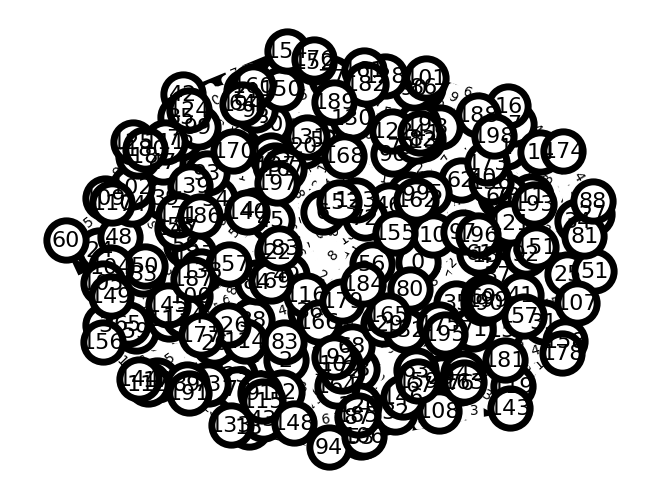

In [31]:
graph = CreateGraph(200)
graph_dgl = dgl.from_networkx(nx_graph=graph)
graph_dgl = graph_dgl.to(TORCH_DEVICE)
q_torch = qubo_dict_to_torch(graph, gen_adj_matrix(graph), torch_dtype=TORCH_DTYPE, torch_device=TORCH_DEVICE)

DrawGraph(graph), q_torch

In [32]:
cut_value_AB, partition_AB = nx.minimum_cut(graph, 0, 120)
cut_value_AB, partition_AB

(506,
 ({0,
   1,
   2,
   3,
   4,
   5,
   6,
   7,
   8,
   9,
   10,
   11,
   12,
   13,
   14,
   15,
   16,
   17,
   18,
   19,
   20,
   21,
   22,
   23,
   24,
   25,
   26,
   27,
   28,
   29,
   30,
   31,
   32,
   33,
   34,
   35,
   36,
   37,
   38,
   39,
   40,
   41,
   42,
   43,
   44,
   45,
   46,
   47,
   48,
   49,
   50,
   51,
   52,
   53,
   54,
   55,
   56,
   57,
   58,
   59,
   60,
   61,
   62,
   63,
   64,
   65,
   66,
   67,
   68,
   69,
   70,
   71,
   72,
   73,
   74,
   75,
   76,
   77,
   78,
   79,
   80,
   81,
   82,
   83,
   84,
   85,
   86,
   87,
   88,
   89,
   90,
   91,
   92,
   93,
   94,
   95,
   96,
   97,
   98,
   99,
   100,
   101,
   102,
   103,
   104,
   105,
   106,
   107,
   108,
   109,
   110,
   111,
   112,
   113,
   114,
   115,
   116,
   117,
   118,
   119,
   121,
   122,
   123,
   124,
   125,
   126,
   127,
   128,
   129,
   130,
   131,
   132,
   133,
   134,
   135,
   136,
   137,
   138,


In [33]:
# Runing multiple instance of GNN

best_gnn_final = []
best_gnn_bitstring = []
best_cut_value = torch.inf
best_gnn_model = None
best_index = 0
terminal_nodes = {0: 0, 120: 1}
for i in range(5):

    n, d, p, graph_type, number_epochs, learning_rate, PROB_THRESHOLD, tol, patience, dim_embedding, hidden_dim = hyperParameters(n=200,patience=1000)

    # Establish pytorch GNN + optimizer
    opt_params = {'lr': learning_rate}
    gnn_hypers = {
        'dim_embedding': dim_embedding,
        'hidden_dim': hidden_dim,
        'dropout': 0.0,
        'number_classes': 2,
        'prob_threshold': PROB_THRESHOLD,
        'number_epochs': number_epochs,
        'tolerance': tol,
        'patience': patience,
        'nodes':n
    }

    net, embed, optimizer = get_gnn(n, gnn_hypers, opt_params, TORCH_DEVICE, TORCH_DTYPE)

    trained_net, epoch, final_bitstring, best_bitstring , raw_bitstring= run_gnn_training(
        q_torch, graph_dgl, net, embed, optimizer, int(1e5),
        gnn_hypers['tolerance'], gnn_hypers['patience'], gnn_hypers['prob_threshold'], Loss, terminal_nodes, gnn_hypers['nodes'], gnn_hypers['number_classes'])

    final_cutVale = calculateAllCut(q_torch, final_bitstring)
    best_cutValue = calculateAllCut(q_torch, best_bitstring)

    if torch.min(final_cutVale, best_cutValue) < best_cut_value:
        best_cut_value = torch.min(final_cutVale, best_cutValue)
        best_gnn_final = final_bitstring
        best_gnn_bitstring = best_bitstring
        best_gnn_model = trained_net
        best_index = i

best_gnn_bitstring, best_gnn_final, best_cut_value

Epoch: 0, Loss: 74940.984375
Epoch: 1000, Loss: 54148.0625
Epoch: 2000, Loss: 51068.6015625
Epoch: 3000, Loss: 50654.95703125
Epoch: 4000, Loss: 50544.29296875
Epoch: 5000, Loss: 50503.94140625
Epoch: 6000, Loss: 50486.6640625
Epoch: 7000, Loss: 50478.54296875
Epoch: 8000, Loss: 50474.515625
Epoch: 9000, Loss: 50472.4296875
Epoch: 10000, Loss: 50471.32421875
Epoch: 11000, Loss: 50470.734375
Epoch: 12000, Loss: 50470.40625
Epoch: 13000, Loss: 50470.2265625
Epoch: 14000, Loss: 50470.12890625
Epoch: 15000, Loss: 50470.07421875
Epoch: 16000, Loss: 50470.0390625
Epoch: 17000, Loss: 50470.0234375
Epoch: 18000, Loss: 50470.015625
Epoch: 19000, Loss: 50470.0078125
Epoch: 20000, Loss: 50470.00390625
Stopping early on epoch 20273 (patience: 1000)
GNN training (n=200) took 52.378
GNN final continuous loss: 50470.00390625
GNN best continuous loss: 50470.00390625
Epoch: 0, Loss: 74939.046875
Epoch: 1000, Loss: 54425.6640625
Epoch: 2000, Loss: 51014.17578125
Epoch: 3000, Loss: 50631.7109375
Epoch: 4

(tensor([[1, 0],
         [1, 0],
         [1, 0],
         [1, 0],
         [1, 0],
         [1, 0],
         [1, 0],
         [1, 0],
         [1, 0],
         [1, 0],
         [1, 0],
         [1, 0],
         [1, 0],
         [1, 0],
         [1, 0],
         [1, 0],
         [1, 0],
         [1, 0],
         [1, 0],
         [1, 0],
         [1, 0],
         [1, 0],
         [1, 0],
         [1, 0],
         [1, 0],
         [1, 0],
         [1, 0],
         [1, 0],
         [1, 0],
         [1, 0],
         [1, 0],
         [1, 0],
         [1, 0],
         [1, 0],
         [1, 0],
         [1, 0],
         [1, 0],
         [1, 0],
         [1, 0],
         [1, 0],
         [1, 0],
         [1, 0],
         [1, 0],
         [1, 0],
         [1, 0],
         [1, 0],
         [1, 0],
         [1, 0],
         [1, 0],
         [1, 0],
         [1, 0],
         [1, 0],
         [1, 0],
         [1, 0],
         [1, 0],
         [1, 0],
         [1, 0],
         [1, 0],
         [1, 0

analyze carefully, is the new loss function (A*HA + c*CH) compatible with both my_GCN and gpt_GCN. Make sure the terminals are always pre-determined and are in separate partition, and we get the minimum cut. The probabilities, in the very end after the training is complete, we will make probability greater than 0.5 to be 1 and less than 0.5 to be 0. So lets say for node 3 (non-terminal node), the probability is [0.4, 0.3, 0.8], so the final probability for node 3 will be [0,0,1]

In [34]:
best_gnn_bitstring, best_gnn_final, best_cut_value, best_index

(tensor([[1, 0],
         [1, 0],
         [1, 0],
         [1, 0],
         [1, 0],
         [1, 0],
         [1, 0],
         [1, 0],
         [1, 0],
         [1, 0],
         [1, 0],
         [1, 0],
         [1, 0],
         [1, 0],
         [1, 0],
         [1, 0],
         [1, 0],
         [1, 0],
         [1, 0],
         [1, 0],
         [1, 0],
         [1, 0],
         [1, 0],
         [1, 0],
         [1, 0],
         [1, 0],
         [1, 0],
         [1, 0],
         [1, 0],
         [1, 0],
         [1, 0],
         [1, 0],
         [1, 0],
         [1, 0],
         [1, 0],
         [1, 0],
         [1, 0],
         [1, 0],
         [1, 0],
         [1, 0],
         [1, 0],
         [1, 0],
         [1, 0],
         [1, 0],
         [1, 0],
         [1, 0],
         [1, 0],
         [1, 0],
         [1, 0],
         [1, 0],
         [1, 0],
         [1, 0],
         [1, 0],
         [1, 0],
         [1, 0],
         [1, 0],
         [1, 0],
         [1, 0],
         [1, 0

# Graph 6 (2-way parition)

In [35]:
graph = CreateGraph(1000)
graph_dgl = dgl.from_networkx(nx_graph=graph)
graph_dgl = graph_dgl.to(TORCH_DEVICE)
q_torch = qubo_dict_to_torch(graph, gen_adj_matrix(graph), torch_dtype=TORCH_DTYPE, torch_device=TORCH_DEVICE)

q_torch

Number of edges: 250207
Sample edges: [(0, 2, {'weight': 10, 'capacity': 10}), (0, 4, {'weight': 3, 'capacity': 3}), (0, 8, {'weight': 3, 'capacity': 3}), (0, 9, {'weight': 3, 'capacity': 3}), (0, 11, {'weight': 4, 'capacity': 4})]


tensor([[ 0.,  0., 10.,  ...,  0.,  4.,  0.],
        [ 0.,  0.,  1.,  ...,  1.,  2.,  4.],
        [10.,  1.,  0.,  ...,  0., 10.,  8.],
        ...,
        [ 0.,  1.,  0.,  ...,  0.,  0.,  8.],
        [ 4.,  2., 10.,  ...,  0.,  0.,  0.],
        [ 0.,  4.,  8.,  ...,  8.,  0.,  0.]])

In [36]:
cut_value_AB, partition_AB = nx.minimum_cut(graph, 0, 660)
cut_value_AB, partition_AB

(2489,
 ({0},
  {1,
   2,
   3,
   4,
   5,
   6,
   7,
   8,
   9,
   10,
   11,
   12,
   13,
   14,
   15,
   16,
   17,
   18,
   19,
   20,
   21,
   22,
   23,
   24,
   25,
   26,
   27,
   28,
   29,
   30,
   31,
   32,
   33,
   34,
   35,
   36,
   37,
   38,
   39,
   40,
   41,
   42,
   43,
   44,
   45,
   46,
   47,
   48,
   49,
   50,
   51,
   52,
   53,
   54,
   55,
   56,
   57,
   58,
   59,
   60,
   61,
   62,
   63,
   64,
   65,
   66,
   67,
   68,
   69,
   70,
   71,
   72,
   73,
   74,
   75,
   76,
   77,
   78,
   79,
   80,
   81,
   82,
   83,
   84,
   85,
   86,
   87,
   88,
   89,
   90,
   91,
   92,
   93,
   94,
   95,
   96,
   97,
   98,
   99,
   100,
   101,
   102,
   103,
   104,
   105,
   106,
   107,
   108,
   109,
   110,
   111,
   112,
   113,
   114,
   115,
   116,
   117,
   118,
   119,
   120,
   121,
   122,
   123,
   124,
   125,
   126,
   127,
   128,
   129,
   130,
   131,
   132,
   133,
   134,
   135,
   136,
   137

In [37]:
# Runing multiple instance of GNN

best_gnn_final = []
best_gnn_bitstring = []
best_cut_value = torch.inf
best_gnn_model = None
best_index = 0
terminal_nodes = {0: 0, 660: 1}
for i in range(3):

    n, d, p, graph_type, number_epochs, learning_rate, PROB_THRESHOLD, tol, patience, dim_embedding, hidden_dim = hyperParameters(n=1000,patience=1000)

    # Establish pytorch GNN + optimizer
    opt_params = {'lr': learning_rate}
    gnn_hypers = {
        'dim_embedding': dim_embedding,
        'hidden_dim': hidden_dim,
        'dropout': 0.0,
        'number_classes': 2,
        'prob_threshold': PROB_THRESHOLD,
        'number_epochs': number_epochs,
        'tolerance': tol,
        'patience': patience,
        'nodes':n
    }

    net, embed, optimizer = get_gnn(n, gnn_hypers, opt_params, TORCH_DEVICE, TORCH_DTYPE)

    trained_net, epoch, final_bitstring, best_bitstring , raw_bitstring= run_gnn_training(
        q_torch, graph_dgl, net, embed, optimizer, int(1e5),
        gnn_hypers['tolerance'], gnn_hypers['patience'], gnn_hypers['prob_threshold'], Loss, terminal_nodes, gnn_hypers['nodes'], gnn_hypers['number_classes'])

    final_cutVale = calculateAllCut(q_torch, final_bitstring)
    best_cutValue = calculateAllCut(q_torch, best_bitstring)

    if torch.min(final_cutVale, best_cutValue) < best_cut_value:
        best_cut_value = torch.min(final_cutVale, best_cutValue)
        best_gnn_final = final_bitstring
        best_gnn_bitstring = best_bitstring
        best_gnn_model = trained_net
        best_index = i
    print(torch.min(final_cutVale, best_cutValue))

best_gnn_bitstring, best_gnn_final, best_cut_value

Epoch: 0, Loss: 1877346.5
Epoch: 1000, Loss: 1276599.5
Epoch: 2000, Loss: 1258363.125
Epoch: 3000, Loss: 1256133.875
Epoch: 4000, Loss: 1255503.5
Epoch: 5000, Loss: 1255260.875
Epoch: 6000, Loss: 1255152.25
Epoch: 7000, Loss: 1255099.375
Epoch: 8000, Loss: 1255072.125
Epoch: 9000, Loss: 1255057.625
Epoch: 10000, Loss: 1255049.75
Epoch: 11000, Loss: 1255045.5
Epoch: 12000, Loss: 1255043.125
Epoch: 13000, Loss: 1255041.75
Epoch: 14000, Loss: 1255041.0
Epoch: 15000, Loss: 1255040.625
Epoch: 16000, Loss: 1255040.375
Epoch: 17000, Loss: 1255040.25
Stopping early on epoch 17198 (patience: 1000)
GNN training (n=1000) took 500.595
GNN final continuous loss: 1255040.25
GNN best continuous loss: 1255040.25
tensor(2677., dtype=torch.float64)
Epoch: 0, Loss: 1878443.75
Epoch: 1000, Loss: 1281863.125
Epoch: 2000, Loss: 1259184.875
Epoch: 3000, Loss: 1256402.875
Epoch: 4000, Loss: 1255617.0
Epoch: 5000, Loss: 1255315.0
Epoch: 6000, Loss: 1255179.75
Epoch: 7000, Loss: 1255113.875
Epoch: 8000, Loss: 1

KeyboardInterrupt: 

# Graph 6 (3-way cut)

Number of edges: 6
Sample edges: [(0, 1, {'weight': 2, 'capacity': 2}), (0, 2, {'weight': 6, 'capacity': 6}), (0, 3, {'weight': 3, 'capacity': 3}), (1, 2, {'weight': 7, 'capacity': 7}), (1, 3, {'weight': 6, 'capacity': 6})]
Number of edges: 6
Sample edges: [(0, 1, {'weight': 2, 'capacity': 2}), (0, 2, {'weight': 7, 'capacity': 7}), (0, 3, {'weight': 6, 'capacity': 6}), (1, 2, {'weight': 9, 'capacity': 9}), (1, 3, {'weight': 4, 'capacity': 4})]
Number of edges: 6
Sample edges: [(0, 1, {'weight': 4, 'capacity': 4}), (0, 2, {'weight': 2, 'capacity': 2}), (0, 3, {'weight': 4, 'capacity': 4}), (1, 2, {'weight': 6, 'capacity': 6}), (1, 3, {'weight': 1, 'capacity': 1})]


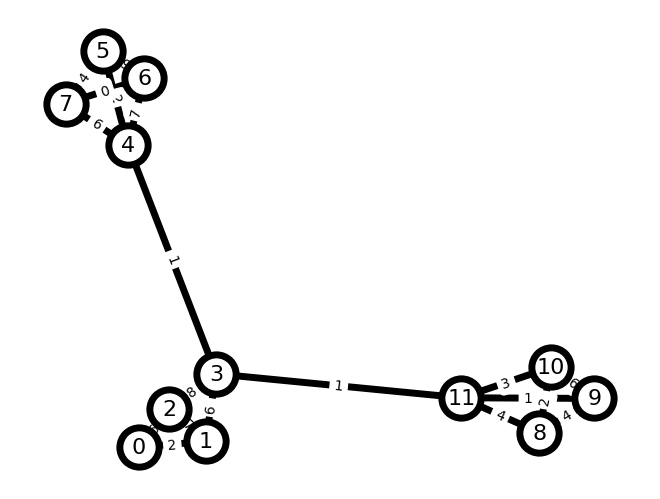

In [47]:
G = CreateGraphEdgeChance(4, 1)
H = CreateGraphEdgeChance(4, 1)
M = CreateGraphEdgeChance(4, 1)
graph1 = nx.disjoint_union(G, H)
graph1.add_edge(3, 4, weight=1, capacity=1)

graph = nx.disjoint_union(graph1, M)
graph.add_edge(3, 11, weight=1, capacity=1)
DrawGraph(graph)

In [48]:
graph_dgl = dgl.from_networkx(nx_graph=graph)
graph_dgl = graph_dgl.to(TORCH_DEVICE)
q_torch = qubo_dict_to_torch(graph, gen_adj_matrix(graph), torch_dtype=TORCH_DTYPE, torch_device=TORCH_DEVICE)

q_torch

tensor([[0., 2., 6., 3., 0., 0., 0., 0., 0., 0., 0., 0.],
        [2., 0., 7., 6., 0., 0., 0., 0., 0., 0., 0., 0.],
        [6., 7., 0., 8., 0., 0., 0., 0., 0., 0., 0., 0.],
        [3., 6., 8., 0., 1., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 1., 0., 2., 7., 6., 0., 0., 0., 0.],
        [0., 0., 0., 0., 2., 0., 9., 4., 0., 0., 0., 0.],
        [0., 0., 0., 0., 7., 9., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 6., 4., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 4., 2., 4.],
        [0., 0., 0., 0., 0., 0., 0., 0., 4., 0., 6., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 2., 6., 0., 3.],
        [0., 0., 0., 1., 0., 0., 0., 0., 4., 1., 3., 0.]])

In [62]:
cut_value_AB, partition_AB = nx.minimum_cut(graph, 0, 4)
cut_value_AB, partition_AB

(1, ({0, 1, 2, 3, 8, 9, 10, 11}, {4, 5, 6, 7}))

In [72]:
# Runing multiple instance of GNN

best_gnn_final = []
best_gnn_bitstring = []
best_cut_value = torch.inf
best_gnn_model = None
best_index = 0
terminal_nodes = {0: 2, 9: 0, 5:1}
for i in range(5):

    n, d, p, graph_type, number_epochs, learning_rate, PROB_THRESHOLD, tol, patience, dim_embedding, hidden_dim = hyperParameters(n=12,patience=1000)

    # Establish pytorch GNN + optimizer
    opt_params = {'lr': learning_rate}
    gnn_hypers = {
        'dim_embedding': dim_embedding+1,
        'hidden_dim': hidden_dim,
        'dropout': 0.0,
        'number_classes': 3,
        'prob_threshold': PROB_THRESHOLD,
        'number_epochs': number_epochs,
        'tolerance': tol,
        'patience': patience,
        'nodes':n
    }

    net, embed, optimizer = get_gnn(n, gnn_hypers, opt_params, TORCH_DEVICE, TORCH_DTYPE)

    trained_net, epoch, final_bitstring, best_bitstring , raw_bitstring= run_gnn_training(
        q_torch, graph_dgl, net, embed, optimizer, int(1e5),
        gnn_hypers['tolerance'], gnn_hypers['patience'], gnn_hypers['prob_threshold'], Loss, terminal_nodes, gnn_hypers['nodes'], gnn_hypers['number_classes'])

    final_cutVale = calculateAllCut(q_torch, final_bitstring)
    best_cutValue = calculateAllCut(q_torch, best_bitstring)

    if torch.min(final_cutVale, best_cutValue) < best_cut_value:
        best_cut_value = torch.min(final_cutVale, best_cutValue)
        best_gnn_final = final_bitstring
        best_gnn_bitstring = best_bitstring
        best_gnn_model = trained_net
        best_index = i
    print(torch.min(final_cutVale, best_cutValue))

best_gnn_bitstring, best_gnn_final, best_cut_value

Epoch: 0, Loss: 873.9842529296875
Epoch: 1000, Loss: 860.8597412109375
Epoch: 2000, Loss: 810.401611328125
Epoch: 3000, Loss: 774.8953857421875
Epoch: 4000, Loss: 761.91455078125
Epoch: 5000, Loss: 756.285400390625
Epoch: 6000, Loss: 753.20703125
Epoch: 7000, Loss: 751.192138671875
Epoch: 8000, Loss: 749.6873168945312
Epoch: 9000, Loss: 748.45458984375
Epoch: 10000, Loss: 747.3478393554688
Epoch: 11000, Loss: 746.192138671875
Epoch: 12000, Loss: 744.8695068359375
Epoch: 13000, Loss: 743.180908203125
Epoch: 14000, Loss: 740.2227783203125
Epoch: 15000, Loss: 736.491455078125
Epoch: 16000, Loss: 732.554443359375
Epoch: 17000, Loss: 728.4215698242188
Epoch: 18000, Loss: 724.413330078125
Epoch: 19000, Loss: 720.87890625
Epoch: 20000, Loss: 718.1986083984375
Epoch: 21000, Loss: 716.157958984375
Epoch: 22000, Loss: 714.4241943359375
Epoch: 23000, Loss: 712.9324951171875
Epoch: 24000, Loss: 711.6465454101562
Epoch: 25000, Loss: 710.5390625
Epoch: 26000, Loss: 709.586669921875
Epoch: 27000, Los

(tensor([[0, 0, 1],
         [0, 1, 0],
         [0, 1, 0],
         [0, 1, 0],
         [0, 1, 0],
         [0, 1, 0],
         [0, 1, 0],
         [0, 1, 0],
         [1, 0, 0],
         [1, 0, 0],
         [1, 0, 0],
         [1, 0, 0]]),
 tensor([[0, 0, 1],
         [0, 1, 0],
         [0, 1, 0],
         [0, 1, 0],
         [0, 1, 0],
         [0, 1, 0],
         [0, 1, 0],
         [0, 1, 0],
         [1, 0, 0],
         [1, 0, 0],
         [1, 0, 0],
         [1, 0, 0]]),
 tensor(12., dtype=torch.float64))

In [68]:
#print(best_gnn_bitstring)
print(Loss(best_gnn_final, q_torch, {0: 0, 9: 1, 5:2}, C=4))

test_ = torch.from_numpy(np.array([[1, 0, 0],
                                   [1, 0, 0],
                                   [1, 0, 0],
                                   [1, 0, 0],
                                   [0, 0, 1],
                                   [0, 0, 1],
                                   [0, 0, 1],
                                   [0, 0, 1],
                                   [0, 1, 0],
                                   [0, 1, 0],
                                   [0, 1, 0],
                                   [0, 1, 0]]) )
print(Loss(test_, q_torch, {0: 0, 9: 1, 5:2}, C=4))


tensor(704.)
tensor(664.)


In [37]:
best_gnn_bitstring[:,1]
best_gnn_bitstring[:,1][50]

tensor(1)

In [39]:
best_gnn_bitstring[:,2]


tensor([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1])

In [44]:
best_gnn_bitstring[:,2][102]

tensor(1)

In [46]:
cut_value_AB, partition_AB = nx.minimum_cut(graph, 99, 100)
cut_value_AB, partition_AB

(1,
 ({0,
   1,
   2,
   3,
   4,
   5,
   6,
   7,
   8,
   9,
   10,
   11,
   12,
   13,
   14,
   15,
   16,
   17,
   18,
   19,
   20,
   21,
   22,
   23,
   24,
   25,
   26,
   27,
   28,
   29,
   30,
   31,
   32,
   33,
   34,
   35,
   36,
   37,
   38,
   39,
   40,
   41,
   42,
   43,
   44,
   45,
   46,
   47,
   48,
   49,
   50,
   51,
   52,
   53,
   54,
   55,
   56,
   57,
   58,
   59,
   60,
   61,
   62,
   63,
   64,
   65,
   66,
   67,
   68,
   69,
   70,
   71,
   72,
   73,
   74,
   75,
   76,
   77,
   78,
   79,
   80,
   81,
   82,
   83,
   84,
   85,
   86,
   87,
   88,
   89,
   90,
   91,
   92,
   93,
   94,
   95,
   96,
   97,
   98,
   99},
  {100,
   101,
   102,
   103,
   104,
   105,
   106,
   107,
   108,
   109,
   110,
   111,
   112,
   113,
   114,
   115,
   116,
   117,
   118,
   119,
   120,
   121,
   122,
   123,
   124,
   125,
   126,
   127,
   128,
   129,
   130,
   131,
   132,
   133,
   134,
   135,
   136,
   137,
 